# Assignment 2

2.2

Write a DES program to verify this for n=1, n=2 and n=4. Make sure that your result
has a high and known statistical significance. How does the number of measurements
required to attain this, depend on $\rho$?

In [14]:
import random
import math
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
# Init variables
RANDOM_SEED = 42
N_helpers = [1, 2, 4]  # Number of machines in the queue
serveTime = 6          # Minutes it takes to help a customer
lambdaIAT = 6          # Create a customer every ~7 minutes
SIM_TIME = 80          # Simulation time in minutes
NRUNS = 100             # Amount of runs
customerCount = 50   # Amount of customers

# Choose your queueing system
# resources = [simpy.PriorityResource]
resources = [simpy.Resource]
# resources = [simpy.Resource, simpy.PriorityResource]

# Create Queue object
class Queue(object):
    def __init__(self, env, N, serveTime, resource):
        self.env = env
        self.machine = resource(env, N)
        self.serveTime = serveTime
        self.customerHelped = 0
        self.helperN = N

    def helped(self, customer, customerServeWait=serveTime):
        yield self.env.timeout(customerServeWait)

# Customer with its own serviceTime
def customer(env, name, cw, id, customerServeWait, resource):
    customerServeWait = random.randint(serveTime - 5, serveTime + 5)
    enterQueue = env.now
    if resource == simpy.PriorityResource:
        with cw.machine.request(priority=customerServeWait) as request:
            request.name = name
            request.time = customerServeWait
            yield request

            customerStat[cw.helperN].append(env.now - enterQueue)
            yield env.process(cw.helped(name, customerServeWait=customerServeWait))

    elif resource == simpy.Resource:
        with cw.machine.request() as request:
            request.name = name
            request.time = customerServeWait
            yield request

            customerStat[cw.helperN].append(env.now - enterQueue)
            yield env.process(cw.helped(name, customerServeWait=customerServeWait))


def setup(env, N, serveTime, lambdaIAT, customerCount, resource):
    queue = Queue(env, N, serveTime, resource)

    # Create more customers while the simulation is running
    while queue.customerHelped < customerCount:
        s = np.random.poisson(lambdaIAT, customerCount)
        yield env.timeout(s[queue.customerHelped])
        queue.customerHelped += 1
        env.process(
            customer(env, 'customer %d' % queue.customerHelped, queue,
                     queue.customerHelped,
                     (customerCount - queue.customerHelped), resource))

for resource in resources:
    random.seed(RANDOM_SEED)
    customerStat = {}
    for j in range(NRUNS):
        for N in N_helpers:
            customerStat.setdefault(N, [])
            customerStat.setdefault(str(N) + "P", [])
            customerStat[str(N) + "P"].append(lambdaIAT / (N * serveTime))
            env = simpy.Environment()
            env.process(
                setup(env, N, serveTime, lambdaIAT, customerCount, resource))
            env.run()
    
    # Format data    
    customerStatDf = pd.DataFrame({"Helpers": N_helpers, 
                                  "$\rho$": [np.mean(customerStat[str(N)+'P']).round(decimals=2) for N in N_helpers],
                                  "Average": [np.mean(customerStat[N]).round(decimals=2) for N in N_helpers], 
                                  "Variance": [np.var(customerStat[N]).round(decimals=2) for N in N_helpers],
                                  "std.dev": [np.std(customerStat[N]).round(decimals=2) for N in N_helpers]}).set_index('Helpers')
    
    # Print output    
    print(f"For {str(resource)[33:-2]}")
    display(HTML(customerStatDf.T.to_html()))
    print()


For Resource


Helpers,1,2,4
$\rho$,1.00,0.50,0.25
Average,14.55,0.12,0.00
Variance,205.85,0.30,0.00
std.dev,14.35,0.55,0.00


## 2.3

Also compare the result to that for an M/M/1 queue with shortest job first scheduling,
where you always give priority to the smallest jobs.

In [3]:
# Init variables
RANDOM_SEED = 42
N_helpers = [1, 2, 4]  # Number of machines in the queue
waitTime = 6          # Minutes it takes to help a customer
lambdaIAT = 6          # Create a customer every ~7 minutes
SIM_TIME = 80          # Simulation time in minutes
NRUNS = 10             # Amount of runs
customerCount = 1000   # Amount of customers

# Choose your queueing system
# resources = [simpy.PriorityResource]
# resources = [simpy.Resource]
resources = [simpy.Resource, simpy.PriorityResource]


class Queue(object):
    def __init__(self, env, N, waitTime, resource):
        self.env = env
        self.machine = resource(env, N)
        self.waitTime = waitTime
        self.customerHelped = 0
        self.helperN = N

    def helped(self, customer, customerWait=waitTime):
        yield self.env.timeout(customerWait)


def customer(env, name, cw, id, customerWait, resource):
    customerWait = random.randint(waitTime - 5, waitTime + 5)
    enterQueue = env.now
    if resource == simpy.PriorityResource:
        with cw.machine.request(priority=customerWait) as request:
            request.name = name
            request.time = customerWait
            yield request

            customerStat[cw.helperN].append(env.now - enterQueue)
            yield env.process(cw.helped(name, customerWait=customerWait))

    elif resource == simpy.Resource:
        with cw.machine.request() as request:
            request.name = name
            request.time = customerWait
            yield request

            customerStat[cw.helperN].append(env.now - enterQueue)
            yield env.process(cw.helped(name, customerWait=customerWait))


def setup(env, N, waitTime, lambdaIAT, customerCount, resource):
    queue = Queue(env, N, waitTime, resource)

    # Create more customers while the simulation is running
    while queue.customerHelped < customerCount:
        s = np.random.poisson(lambdaIAT, customerCount)
        yield env.timeout(s[queue.customerHelped])
        queue.customerHelped += 1
        env.process(
            customer(env, 'customer %d' % queue.customerHelped, queue,
                     queue.customerHelped,
                     (customerCount - queue.customerHelped), resource))

for resource in resources:
    random.seed(RANDOM_SEED)
    customerStat = {}
    for j in range(NRUNS):
        for N in N_helpers:
            #         print(f"******** N={N} Helpers ********")
            customerStat.setdefault(N, [])
            customerStat.setdefault(str(N) + "P", [])
            customerStat[str(N) + "P"].append(lambdaIAT / (N * waitTime))
            env = simpy.Environment()
            env.process(
                setup(env, N, waitTime, lambdaIAT, customerCount, resource))
            env.run()
    customerStatDf = pd.DataFrame({"Helpers": N_helpers, 
                                  "$\rho$": [np.mean(customerStat[str(N)+'P']).round(decimals=2) for N in N_helpers],
                                  "Average": [np.mean(customerStat[N]).round(decimals=2) for N in N_helpers], 
                                  "Variance": [np.var(customerStat[N]).round(decimals=2) for N in N_helpers],
                                  "std.dev": [np.std(customerStat[N]).round(decimals=2) for N in N_helpers]}).set_index('Helpers')
    print(f"For {str(resource)[33:-2]}")
    display(HTML(customerStatDf.T.to_html()))
    print()


For Resource


Helpers,1,2,4
$\rho$,1.00,0.50,0.25
Average,74.17,0.14,0.00
Variance,3482.87,0.40,0.00
std.dev,59.02,0.63,0.02



For PriorityResource


Helpers,1,2,4
$\rho$,1.00,0.50,0.25
Average,35.09,0.14,0.00
Variance,16765.20,0.41,0.00
std.dev,129.48,0.64,0.02


## 2.4

Now experiment with different service rate distributions. On the one hand try the
M/D/1 and M/D/n queues, on the other hand try a long-tail distribution. For the latter
you may e.g. use a distribution where 75% of the jobs have an exponential distribution
with an average service time of 1.0 and the remaining 25% an exponential distribution
with an average service time of 5.0 (an example of a hyperexponential distribution).

In [4]:
# Init seed
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Init service schemes
serviceScheme = "Long-Tailed"  # Can be "Long-Tailed", "Poisson", "Deterministic", "Inverse", "Random"
serviceSchemes = [
    "Long-Tailed", "Poisson", "Deterministic", "Inverse", "Random"
]
ltLow = 3  # Lower bound long-tailed distribution
ltHigh = 15  # Upper bound long-tailed distribution
chanceLongTail = 0.75 # Chance of longtail lowerbound
randspread = 5  # Spread of the random distribution
invMax = 9 # max waiting time for the inverse waitingtime

# Init simulation specific parameters
N_helpers = [1, 2, 4]  # Number of machines in the queue
waitTime = 6  # Minutes it takes to help a customer
lambdaIAT = 6  # Create a customer every ~7 minutes
SIM_TIME = 80  # Simulation time in minutes
NRUNS = 2  # Amount of runs
customerCount = 20  # Amount of customers

# Choose your queueing system
# resources = [simpy.PriorityResource]
# resources = [simpy.Resource]
resources = [simpy.Resource, simpy.PriorityResource]


class Queue(object):
    def __init__(self, env, N, waitTime, resource):
        self.env = env
        self.machine = resource(env, N)
        self.waitTime = waitTime
        self.customerHelped = 0
        self.helperN = N

    def helped(self, customer, customerWait=waitTime):
        yield self.env.timeout(customerWait)


def customer(env, name, cw, id, customerWait, resource, serviceScheme):
    if serviceScheme == "Long-Tailed":
        rCheck = random.random()
        if rCheck <= 0.75:
            customerWait = np.random.poisson(ltLow*10)/10
        else:
            customerWait = np.random.poisson(ltHigh*10)/10
    elif serviceScheme == "Poisson":
        customerWait = np.random.poisson(waitTime)
    elif serviceScheme == "Random":
        customerWait = random.randint(waitTime - randspread,
                                      waitTime + randspread)
    elif serviceScheme == "Deterministic":
        customerWait = waitTime
    elif serviceScheme == "Inverse":
        customerWait = customerWait
    elif serviceScheme == "Exponential":
        customerWait = np.random.exponential(1/waitTime)

    enterQueue = env.now
    if resource == simpy.PriorityResource:
        with cw.machine.request(priority=customerWait) as request:
            request.name = name
            request.time = customerWait
            yield request

            tmpWait.append(env.now - enterQueue)
            tmpServe.append(customerWait)
            yield env.process(cw.helped(name, customerWait=customerWait))

    elif resource == simpy.Resource:
        with cw.machine.request() as request:
            request.name = name
            request.time = customerWait
            yield request

            tmpWait.append(env.now - enterQueue)
            tmpServe.append(customerWait)
            yield env.process(cw.helped(name, customerWait=customerWait))


def setup(env, N, waitTime, lambdaIAT, customerCount, resource, serviceScheme):
    queue = Queue(env, N, waitTime, resource)
    qServeInv = [i for i in range(invMax,-1,-1) for x in range(math.ceil(customerCount/invMax))]
    # Create more customers while the simulation is running
    while queue.customerHelped < customerCount:
        s = np.random.poisson(lambdaIAT, customerCount)
        yield env.timeout(s[queue.customerHelped])
        queue.customerHelped += 1
        env.process(
            customer(env, 'customer %d' % queue.customerHelped, queue,
                     queue.customerHelped,
                     qServeInv[queue.customerHelped], resource,
                     serviceScheme))


columns = [
    "Rho", "Average", "Variance", "std_dev", "Resource", "Helpers", "run",
    "serviceScheme", "ServeMean"
]

resourceStatsRun = pd.DataFrame(columns=columns)
customerAll = pd.DataFrame(columns=columns)
for serviceScheme in serviceSchemes:
    for resource in resources:

        for N in N_helpers:
            runServe = []
            for j in range(NRUNS):
                tmpWait = []
                tmpServe = []
                env = simpy.Environment()
                env.process(
                    setup(env, N, waitTime, lambdaIAT, customerCount, resource,
                          serviceScheme))
                env.run()

                resourceStatsRun.loc[serviceScheme + "_" + str(resource)[33:-2]
                                     + "_" + str(j) + "_" + str(N)] = [
                                         lambdaIAT / (N * waitTime),
                                         np.mean(tmpWait),
                                         np.var(tmpWait),
                                         np.std(tmpWait),
                                         str(resource)[33:-2], N, j,
                                         serviceScheme,
                                         np.mean(tmpServe)
                                     ]
                runServe.append(np.mean(tmpServe))

            customerAll.loc[serviceScheme + "_" + str(resource)[33:-2] + "_" +
                            str(N)] = [
                                lambdaIAT / (N * waitTime),
                                np.mean(tmpWait),
                                np.var(tmpWait),
                                np.std(tmpWait),
                                str(resource)[33:-2], N, None, serviceScheme,
                                np.mean(runServe)
                            ]

In [5]:
import math
customerCount = 24
len([i for i in range(10,-1,-1) for x in range(math.ceil(customerCount/10))])

33

In [6]:
print(resourceStatsRun.shape)
print(customerAll.shape)

(60, 9)
(30, 9)


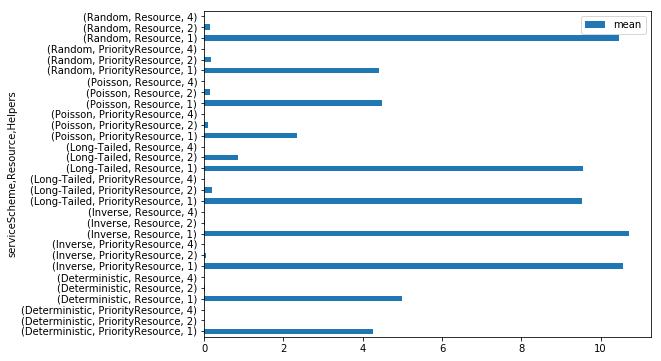

In [23]:
%matplotlib inline
grp = resourceStatsRun.groupby(["serviceScheme", "Resource", "Helpers"])
display(HTML(grp.Average.agg([np.mean]).to_html()))

# grpDescr = grp.describe()
# display(HTML(grpDescr.ServeMean.to_html()))
# display(HTML(grpDescr.Average.to_html()))

fig, ax = plt.subplots(figsize=(8,6))
grp.Average.agg([np.mean]).plot(kind='barh', ax=ax)

In [24]:
display(HTML(grp.ServeMean.agg([np.mean, np.var, np.std]).to_html()))

,Rho,Average,Variance,std_dev,Resource,Helpers,run,serviceScheme,ServeMean
Long-Tailed_Resource_1,1.00,18.025,165.282875,12.856239,Resource,1,None,Long-Tailed,5.7700
Long-Tailed_Resource_2,0.50,1.720,10.486600,3.238302,Resource,2,None,Long-Tailed,5.1575
Long-Tailed_Resource_4,0.25,0.000,0.000000,0.000000,Resource,4,None,Long-Tailed,6.0350
Long-Tailed_PriorityResource_1,1.00,1.255,8.017475,2.831515,PriorityResource,1,None,Long-Tailed,6.4000
Long-Tailed_PriorityResource_2,0.50,0.000,0.000000,0.000000,PriorityResource,2,None,Long-Tailed,6.1100
Long-Tailed_PriorityResource_4,0.25,0.000,0.000000,0.000000,PriorityResource,4,None,Long-Tailed,6.2525
Poisson_Resource_1,1.00,4.650,15.727500,3.965791,Resource,1,None,Poisson,5.3750
Poisson_Resource_2,0.50,0.100,0.090000,0.300000,Resource,2,None,Poisson,6.5000
Poisson_Resource_4,0.25,0.000,0.000000,0.000000,Resource,4,None,Poisson,6.4750
Poisson_PriorityResource_1,1.00,2.900,14.390000,3.793415,PriorityResource,1,None,Poisson,6.0000


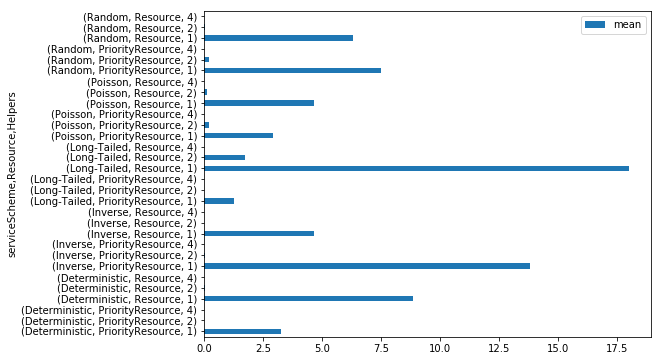

In [22]:
%matplotlib inline
grp = customerAll.groupby(["serviceScheme", "Resource", "Helpers"])
display(HTML(grp.Average.agg([np.mean]).to_html()))
display(HTML(grp.ServeMean.agg([np.mean, np.var, np.std]).to_html()))

# grpDescr = grp.describe()
# display(HTML(grpDescr.ServeMean.to_html()))
# display(HTML(grpDescr.Average.to_html()))

fig, ax = plt.subplots(figsize=(8,6))
grp.Average.agg([np.mean]).plot(kind='barh', ax=ax)

customerAll

In [ ]:
resourceStatsRun

In [52]:
import random
import numpy as np
ne = []
npo = []
re = []
for j in range(10000):
    ne.append(np.random.exponential(12))
    npo.append(np.random.poisson(12))
    re.append(random.expovariate(1/12))
    
print("Numpy exponantial {}".format(np.mean(ne)))
print("Numpy poisson {}".format(np.mean(npo)))
print("Random expovariate {}".format(np.mean(re)))

Numpy exponantial 12.118833298980732
Numpy poisson 11.9967
Random expovariate 11.830659547076042
